CS 4277: Deep Learning Group Project

## CS 4277: *Deep Learning* Group Project
### Members:
- Nicholas Hodge
- Joshua Peeples
- Jonathan Turner

### This project is our attempt at the Stanford RNA 3D Folding Challenge, found at:

https://www.kaggle.com/competitions/stanford-rna-3d-folding

**For this project to run:**

1. Install matplotlib in your Jupyter Kernel: Block [1]
2. Setup correct path files to your train dataset: Block [7] (there is a comment)

**Future work:**

1. Setup validation correctly
2. Test
3. Return Submission.csv as per requirements

In [1]:
# Uncomment and run if matplotlib not installed
# !  python -m pip install matplotlib

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm

# containers to accumulate metrics
batch_loss_history = [] # one entry per batch
epoch_loss_history = [] # one entry per epoch

/home/josh/Documents/Visual Studio/Deep Learning/Term Project/DL-GroupProject-RNA_Folding/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
NUC_TO_IDX = {
    "A": 0,
    "U": 1,
    "C": 2,
    "G": 3,
    "N": 4 # There are characters *other* than the above 4 sometimes. 'N' is standard for "unknown" (apparently)
}
PAD_IDX = 5
VOCAB_SIZE = len(NUC_TO_IDX) + 1

# Annotated to avoid later confusion - Nick
# This is inherits the Dataset class from pytorch to allow for the dataset to be an Iterable (i.e. work a LOT faster)
class RNADataset(Dataset):
    def __init__(self, seq_csv_path, coords_csv_path):
        # Read both train CSVs (the 'labels' csv -> 'coords')
        self.sequences_df = pd.read_csv(seq_csv_path)
        coords_df_raw = pd.read_csv(coords_csv_path)

        # We are going to get the base_id from each row in coords to associate them with the correct sequence.
        # 1SCL_A_5 becomes 1SCL_A
        coords_df_raw["base_id"] = coords_df_raw["ID"].apply(lambda x: "_".join(x.split("_")[:2]))

        # Now we are going to create groups of coords, where each group corresponds with the same sequence
        # Unfortunately some sequences have missing coord values, but I am going to assume that there are potential
        # sequences that have some missing and some not. So:

        # Method to remove entire groups where *any* row has missing coords
        def is_group_valid(group):
            return group[["x_1", "y_1", "z_1"]].notna().all().all() # returns only rows where all columns are good

        valid_groups = [
            group for _, group in coords_df_raw.groupby("base_id") if is_group_valid(group)
        ]

        # Concatenate all valid groups into a new coords_df
        self.coords_df = pd.concat(valid_groups, ignore_index=True)

        # Build groups and valid sequence IDs list
        self.coord_groups = self.coords_df.groupby("base_id")
        self.valid_ids = set(self.coord_groups.groups.keys())

        # Filter sequences to only include those with clean coordinate groups (prevents later tensors from being mishaped)
        self.sequences_df = self.sequences_df[self.sequences_df["target_id"].isin(self.valid_ids)]

    # Optional but Pytorch docs suggest this for 'Sampler' implmentations (might need that?)
    def __len__(self):
        return len(self.sequences_df)

    # Optional but Pytorch docs suggest this for speedup batched samples loading
    def __getitem__(self, idx):
        row = self.sequences_df.iloc[idx]
        seq_id = row["target_id"]
        sequence = row["sequence"]

        token_ids = [NUC_TO_IDX.get(nuc, NUC_TO_IDX["N"]) for nuc in sequence]
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        # Here we introduce standardization to the coordinates

        # TODO: calculate the following values somewhere in the document in case the dataset changes:
        # Currently precalculated values
        mean_x = 80.44731529117061
        std_x = 147.42231938515297
        mean_y = 84.04072703411182
        std_y = 114.92890150429712
        mean_z = 98.61122565112208
        std_z = 119.41066506340083

        coords_standardized = self.coord_groups.get_group(seq_id)[["x_1", "y_1", "z_1"]].values
        coords_standardized[:, 0] = (coords_standardized[:, 0] - mean_x) / std_x
        coords_standardized[:, 1] = (coords_standardized[:, 1] - mean_y) / std_y
        coords_standardized[:, 2] = (coords_standardized[:, 2] - mean_z) / std_z

        coords = torch.tensor(coords_standardized, dtype=torch.float32)

        return token_ids, coords

In [4]:
# Pad sequences in collate_fn
def collate_fn(batch):
    sequences, coords = zip(*batch)

    # Pad sequences with PAD_IDX
    seq_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PAD_IDX)
    coord_padded = torch.nn.utils.rnn.pad_sequence(coords, batch_first=True, padding_value=0.0)

    # Mask should check against PAD_IDX
    mask = (seq_padded != PAD_IDX).unsqueeze(1).unsqueeze(2)

    return seq_padded, coord_padded, mask

In [5]:
# Source: Aladdin Persson on YouTube (then modified to have an encoder-only architecture)

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads, dropout):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, values, keys, query, mask):
        N, value_len, _ = values.shape
        _, key_len, _ = keys.shape
        _, query_len, _ = query.shape

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim)
        # keys shape: (N, key_len, heads, heads_dim)
        # energy shape: (N, heads, query_len, key_len)

        if mask is not None:
            # mask: (batch, 1, 1, seq_len) -> broadcastable to (batch, heads, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e9"))

        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)
        attention = self.dropout(attention)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # after einsum (N, query_len, heads, head_dim) then flatten last two dimensions

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads, dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attention = self.attention(x, x, x, mask)

        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class RNA3DFoldPredictor(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout,
                 max_length):
        super().__init__()
        self.embed_size = embed_size
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList([
            TransformerBlock(embed_size, heads, dropout, forward_expansion)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_size, 3)  # Predict (x, y, z)

    def forward(self, x, mask=None):
        N, seq_len = x.shape

        positions = torch.arange(0, seq_len).unsqueeze(0).expand(N, seq_len).to(x.device)

        out = self.token_embedding(x) + self.position_embedding(positions)
        for layer in self.layers:
            out = layer(out, mask)

        coords = self.fc_out(out)
        return coords

    def predict_multiple(self, x, n_samples=5):
        self.train()  # Activate dropout during inference
        with torch.no_grad():
            outputs = [self(x) for _ in range(n_samples)]
        return torch.stack(outputs)  # Shape: (n_samples, batch_size, seq_len, 3)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)

cuda


In [ ]:
# live‑plotter
plot_display_handle = None   # will hold the DisplayHandle returned by display()

def plot_training_progress(epoch):
    # Draw the loss curves without clearing cell output
    global plot_display_handle

    # build figure
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].plot(batch_loss_history, linewidth=1)
    axs[0].set_title("Batch loss")
    axs[0].set_xlabel("Batch #")
    axs[0].set_ylabel("Mean Squared Error")

    axs[1].plot(epoch_loss_history, marker="o")
    axs[1].set_title("Epoch loss")
    axs[1].set_xlabel("Epoch")

    plt.tight_layout()
    plt.suptitle(f"Training progress after epoch {epoch+1}", y=1.05, fontsize=14)

    # first call then create display, later calls then update it
    if plot_display_handle is None:
        plot_display_handle = display(fig, display_id=True)
    else:
        plot_display_handle.update(fig)

    plt.close(fig)  # prevent duplicate static image output

Max token ID: tensor(5, device='cuda:0')
Embedding size: 6
Output shape: torch.Size([2, 32, 3])


Epoch 1/10: 100%|██████████| 303/303 [00:03<00:00, 95.47batch/s, batch_loss=1.6219] 


Epoch 1/10 | mean_loss: 1.0577 | last_batch_loss: 1.6219


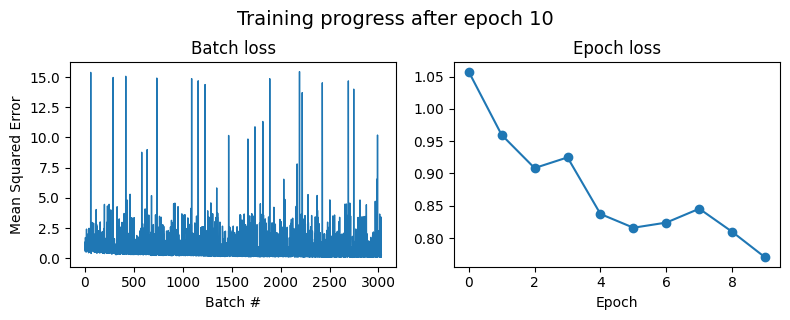

Epoch 2/10: 100%|██████████| 303/303 [00:02<00:00, 103.05batch/s, batch_loss=1.1235] 


Epoch 2/10 | mean_loss: 0.9598 | last_batch_loss: 1.1235


Epoch 3/10: 100%|██████████| 303/303 [00:02<00:00, 103.47batch/s, batch_loss=0.2638] 


Epoch 3/10 | mean_loss: 0.9083 | last_batch_loss: 0.2638


Epoch 4/10: 100%|██████████| 303/303 [00:02<00:00, 103.76batch/s, batch_loss=0.4399] 


Epoch 4/10 | mean_loss: 0.9249 | last_batch_loss: 0.4399


Epoch 5/10: 100%|██████████| 303/303 [00:02<00:00, 103.77batch/s, batch_loss=0.1705] 


Epoch 5/10 | mean_loss: 0.8372 | last_batch_loss: 0.1705


Epoch 6/10: 100%|██████████| 303/303 [00:02<00:00, 103.48batch/s, batch_loss=0.1483]


Epoch 6/10 | mean_loss: 0.8159 | last_batch_loss: 0.1483


Epoch 7/10: 100%|██████████| 303/303 [00:03<00:00, 100.83batch/s, batch_loss=0.6429]


Epoch 7/10 | mean_loss: 0.8239 | last_batch_loss: 0.6429


Epoch 8/10: 100%|██████████| 303/303 [00:02<00:00, 103.62batch/s, batch_loss=0.1100]


Epoch 8/10 | mean_loss: 0.8454 | last_batch_loss: 0.1100


Epoch 9/10: 100%|██████████| 303/303 [00:03<00:00, 99.62batch/s, batch_loss=0.4007]  


Epoch 9/10 | mean_loss: 0.8096 | last_batch_loss: 0.4007


Epoch 10/10: 100%|██████████| 303/303 [00:03<00:00, 100.15batch/s, batch_loss=0.2569] 


Epoch 10/10 | mean_loss: 0.7699 | last_batch_loss: 0.2569


In [ ]:
dataset = RNADataset("./data/train_sequences.csv", "./data/train_labels.csv") # replace with your *actual* path
loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
# Ran at batch_size=2 due to memory constraints FYI

model = RNA3DFoldPredictor(
    vocab_size=VOCAB_SIZE,
    embed_size=64,
    num_layers=4,
    heads=4,
    forward_expansion=4,
    dropout=0.2,
    max_length=4298, # nearest multiple of 2 is 8192...actual max is 4298
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

test_batch = next(iter(loader))
seqs, coords, mask = [x.to(device) for x in test_batch]

print("Max token ID:", torch.max(seqs))  # Should be <= 3
print("Embedding size:", model.token_embedding.num_embeddings)  # Should be 4

with torch.no_grad():
    outputs = model(seqs, mask)
print("Output shape:", outputs.shape)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_num = 0
    valid_batches = 0 # number of batches that actually updated the model
    last_batch_loss = None # loss of the most recent successful batch
    window_losses = [] # collects losses to compute 50 batch running mean

    # tqdm bar stays in the terminal after finishing (leave=True)
    batch_iterator = tqdm(
        loader,
        desc=f"Epoch {epoch+1}/{num_epochs}",
        unit="batch",
        leave=True,
        position=0,
    )

    for batch_num, (seqs, coords, mask) in enumerate(batch_iterator, start=1):
        # print("Max token ID in batch:", torch.max(seqs))
        seqs, coords, mask = seqs.to(device), coords.to(device), mask.to(device)

        # check for any NaN values
        if torch.isnan(coords).any() or torch.isinf(coords).any():
            batch_iterator.write(f"WARNING: NaN/Inf found in target coordinates in batch {batch_num}! Skipping batch.")
            continue

        optimizer.zero_grad()
        outputs = model(seqs, mask)

        # mask padding tokens only
        non_pad_mask = (seqs != PAD_IDX) # Shape: (batch_size, seq_len)
        outputs_masked = outputs[non_pad_mask]
        coords_masked = coords[non_pad_mask]

        # Calculate loss ONLY on non-padded elements
        if outputs_masked.nelement() == 0:
            batch_iterator.write(f"WARNING: Only padding elements in batch {batch_num}! Skipping batch.")
            continue

        loss = criterion(outputs_masked, coords_masked)

        # Skip if loss is NaN or Inf
        if torch.isnan(loss) or torch.isinf(loss):
            batch_iterator.write(f"WARNING: NaN detected in loss for batch {batch_num}! Skipping batch.")
            # Add more debugging here if needed: print outputs_masked, coords_masked
            continue # Skip optimization step for this batch

        # Backpropagation
        loss.backward()
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        last_batch_loss = loss.item()
        batch_loss_history.append(last_batch_loss)
        window_losses.append(last_batch_loss)

        total_loss += last_batch_loss
        valid_batches += 1

        # update tqdm bar postfix
        batch_iterator.set_postfix({"batch_loss": f"{last_batch_loss:.4f}"})

        # Every 50 valid batches, print the running mean and reset the window (disabled because it's spammy)
        if len(window_losses) == 50:
            mean50 = sum(window_losses) / 50
            # print(f"Mean loss over batches {batch_num-49}-{batch_num}: {mean50:.4f}")
            window_losses.clear()

    # Epoch‑level summary
    if valid_batches > 0:
        epoch_loss = total_loss / valid_batches
        epoch_loss_history.append(epoch_loss)
        print(
            f"Epoch {epoch+1}/{num_epochs}"
            f" | mean_loss: {epoch_loss:.4f}"
            f" | last_batch_loss: {last_batch_loss:.4f}"
        )
    else:
        print(f"Epoch {epoch+1} had no valid batches or zero total loss.")

    # live plot (comment out for end‑of‑training plot only)
    plot_training_progress(epoch)